In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms
from gradio_demo.model.utils import output_conv_size

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current device is: {device}")


/teamspace/studios/this_studio/ml-deploy/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Current device is: cuda


Loading the dataset
---

In [2]:
dataset = load_dataset("Xenova/quickdraw-small")

preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize((0,), (1,))
    ]
)


def preprocess_ops(examples):
    examples["image"] = [preprocess(image) for image in examples["image"]]
    return examples


dataset.set_transform(preprocess_ops)

In [3]:
train_dataset, test_dataset, val_dataset = (
    dataset["train"],
    dataset["test"],
    dataset["valid"],
)
train_dataset = train_dataset.shard(num_shards=3, index=0)
names = train_dataset.features["label"].names
n_classes = len(names)
print(f"size of trainset: {len(train_dataset)}, testset: {len(test_dataset)}")

size of trainset: 1500000, testset: 250000


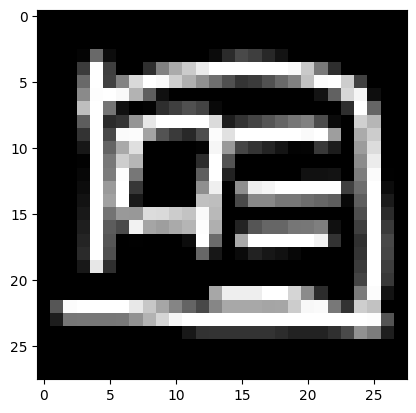

In [4]:
import json

with open("labels.json", "w") as f:
    json.dump(names, f)


def id_to_class(idx):
    return names[idx]


# visualizing an example
idx = torch.randint(0, 100, (1,))
img, label = test_dataset[idx]["image"], test_dataset[idx]["label"]
img = img[0].squeeze(dim=0)
plt.imshow(img, cmap="gray")

Model architechture
---

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current device is: {device}")


class CNN(nn.Module):
    def __init__(self, n_filters, hidden_dim, n_layers, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, n_filters, 3, padding =1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(n_filters, 2 * n_filters, 3, padding = 1),
            nn.BatchNorm2d(2 * n_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(2*n_filters, 4*n_filters, 3, padding=1),
            nn.BatchNorm2d(4*n_filters),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )


        # self.conv1 = nn.Conv2d(1, n_filters, conv_kernel_size)
        # self.relu1 = nn.ReLU()
        # self.maxpool1 = nn.MaxPool2d(maxpool_kernel_size)
        # self.conv2 = nn.Conv2d(n_filters, 2*n_filters, conv_kernel_size)
        # self.relu2 = nn.ReLU()
        # self.maxpool2 = nn.MaxPool2d(maxpool_kernel_size)
        # self.input_dim = output_conv_size(img.shape[0], img.shape[1],conv_kernel_size=conv_kernel_size,maxpool_kernel_size=maxpool_kernel_size,n_filters=n_filters)#960

        self.flatten = nn.Flatten()
        self.input_dim = 1080# 2940#1500 # 960
        self.inp_layer = nn.Linear(self.input_dim, hidden_dim)
        self.classifier = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.BatchNorm1d(hidden_dim),
                    nn.ReLU(),
                    nn.Dropout(p=0.5),
                )
                for i in range(n_layers)
            ]
        )
        self.out_layer = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.inp_layer(torch.flatten(x, start_dim=1))
        for layer in self.classifier:
            x = layer(x)
        x = self.out_layer(x)
        return x

Current device is: cuda


In [6]:
params = {"n_filters": 30, "hidden_dim": 256, "n_layers": 2, "n_classes": n_classes}
model = CNN(**params).to(device)
n_params = sum([p.numel() for p in model.parameters()])
print(f"Number of params {n_params}")

Number of params 579909


In [7]:
# hyperparameters
lr = 1e-3
batch_size = 512
n_epochs = 6
num_workers = 40

# optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay = 1e-4)
criterion = nn.CrossEntropyLoss()

trainLoader, testLoader = (
    DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers),
    DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers),
)

/teamspace/studios/this_studio/ml-deploy/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training loop
---

In [8]:
# def train(model, trainLoader, testLoader, criterion, optimizer, n_epochs, device):
#     train_losses = []
#     train_accs = []
#     test_losses = []
#     test_accs = []
#     for epoch in range(1, n_epochs + 1):
#         model.train()
#         train_loss = 0
#         train_acc = 0
#         for batch in tqdm(trainLoader):
#             data, labels = batch["image"].to(device), batch["label"].to(device)
#             out = model(data)
#             preds = out.argmax(dim=1)
#             loss = criterion(out, labels)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()
#             train_acc += (preds == labels).sum().item()

#         train_loss /= len(trainLoader)
#         train_acc /= len(trainLoader.dataset)
#         train_accs.append(train_acc)
#         train_losses.append(train_loss)

#         model.eval()
#         test_loss = 0
#         test_acc = 0
#         with torch.no_grad():
#             for batch in tqdm(testLoader, disable=True):
#                 data, labels = batch["image"].to(device), batch["label"].to(device)
#                 out = model(data)
#                 loss = criterion(out, labels)
#                 preds = out.argmax(dim=1)
#                 test_loss += loss.item()
#                 test_acc += (preds == labels).sum().item()

#         test_loss /= len(testLoader)
#         test_acc /= len(testLoader.dataset)
#         test_accs.append(test_acc)
#         test_losses.append(test_loss)

#         print(
#             f"epoch {epoch} | train loss {train_loss:.3f} train acc {train_acc:.2f} | test loss {test_loss:.3f} test acc {test_acc:.2f}"
#         )
#     return train_losses, train_accs, test_losses, test_accs


def train(model, trainLoader, testLoader, criterion, optimizer, n_epochs, device):
    train_losses, train_accs, test_losses, test_accs = [], [], [], []
    
    # epoch_bar = tqdm(range(1, n_epochs + 1), desc="Overall Training", leave=True)
    for epoch in range(1, n_epochs + 1):
        # -------------------------
        # 🔹 TRAINING PHASE
        # -------------------------
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        progress = tqdm(trainLoader, desc=f"Epoch {epoch}/{n_epochs}", leave=False)

        for batch in progress:
            data, labels = batch["image"].to(device), batch["label"].to(device)
            out = model(data)
            loss = criterion(out, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            preds = out.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            running_loss += loss.item()

            # update tqdm bar
            progress.set_postfix({
                "train_loss": f"{running_loss / (total / labels.size(0)):.4f}",
                "train_acc": f"{correct / total:.3f}"
            })

        # compute final training stats for the epoch
        train_loss = running_loss / len(trainLoader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # -------------------------
        # 🔹 VALIDATION PHASE
        # -------------------------
        model.eval()
        test_loss, test_correct, test_total = 0.0, 0, 0

        with torch.no_grad():
            for batch in testLoader:
                data, labels = batch["image"].to(device), batch["label"].to(device)
                out = model(data)
                loss = criterion(out, labels)

                preds = out.argmax(dim=1)
                test_correct += (preds == labels).sum().item()
                test_total += labels.size(0)
                test_loss += loss.item()

        test_loss /= len(testLoader)
        test_acc = test_correct / test_total
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        # -------------------------
        # 🔹 SUMMARY PRINT
        # -------------------------
        print(f"✅ Epoch {epoch}/{n_epochs} completed | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.3f} | "
              f"Test Loss: {test_loss:.4f} Acc: {test_acc:.3f}")

    return train_losses, train_accs, test_losses, test_accs

In [9]:
train_losses, train_accs, test_losses, test_accs = train(
    model, trainLoader, testLoader, criterion, optimizer, n_epochs, device
)

✅ Epoch 1/6 completed | Train Loss: 2.8716 Acc: 0.356 | Test Loss: 1.9950 Acc: 0.533


✅ Epoch 2/6 completed | Train Loss: 2.3304 Acc: 0.458 | Test Loss: 1.8038 Acc: 0.572


✅ Epoch 3/6 completed | Train Loss: 2.2149 Acc: 0.482 | Test Loss: 1.7546 Acc: 0.584


✅ Epoch 4/6 completed | Train Loss: 2.1482 Acc: 0.497 | Test Loss: 1.7046 Acc: 0.593


✅ Epoch 5/6 completed | Train Loss: 2.1033 Acc: 0.507 | Test Loss: 1.6695 Acc: 0.600


✅ Epoch 6/6 completed | Train Loss: 2.0703 Acc: 0.514 | Test Loss: 1.6425 Acc: 0.607


In [11]:
torch.save(model.state_dict(), 'weights/cnn_3_conv.pth')